In [3]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import label_binarize

In [4]:
class DataLoaderX:
    def __init__(self, path, test_split, val_split, batch_size):
        self.path = path
        self.test_split = test_split
        self.val_split = val_split
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.Resize((64, 64)),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def load_data(self):
        dataset = datasets.ImageFolder(root=self.path, transform=self.transform)
        test_size = int(len(dataset) * self.test_split)
        val_size = int(len(dataset) * self.val_split)
        train_size = len(dataset) - val_size - test_size
        train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
        return (
            DataLoader(train_dataset, self.batch_size, shuffle=True),
            DataLoader(test_dataset, self.batch_size, shuffle=False),
            DataLoader(val_dataset, self.batch_size, shuffle=False)
        )


In [5]:
class ModelTraining:
    def __init__(self, model, train_loader, val_loader, device, num_epochs):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_epochs = num_epochs
        self.optimizer = optim.Adam(model.parameters(), lr=0.0001)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def train_epoch(self):
        self.model.to(self.device)  # Ensure the model is on the right device
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in self.train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(self.train_loader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    def validate_epoch(self):
        self.model.to(self.device)  # Ensure the model is on the right device
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(self.val_loader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy

    def train(self):
        for epoch in range(self.num_epochs):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.validate_epoch()

            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            print(f'Epoch {epoch + 1}/{self.num_epochs}, '
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


In [6]:
class EvaluationAndPlotting:
    @staticmethod
    def plot_training_results(train_losses, val_losses, train_accs, val_accs):
        # Plotting Training and Validation Loss
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting Training and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    @staticmethod
    def plot_roc_curve(num_classes, y_test, y_score):
        # Compute and plot the ROC curve and ROC area for each class
        fpr, tpr, roc_auc = {}, {}, {}
        y_test = label_binarize(y_test, classes=[i for i in range(num_classes)])
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    @staticmethod
    def plot_confusion_matrix(cm, classes):
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    @staticmethod
    def evaluate_and_plot(model, test_loader, device, num_classes, train_losses, train_accs, val_losses, val_accs):
        EvaluationAndPlotting.plot_training_results(train_losses, val_losses, train_accs, val_accs)
        
        model.eval()
        model.to(device)
        features, y_true, y_pred, y_score = [], [], [], []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                features.extend(outputs.cpu().detach().numpy())
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(torch.max(outputs, 1)[1].cpu().numpy())
                y_score.extend(outputs.cpu().numpy())

        # ROC curve and Confusion Matrix
        EvaluationAndPlotting.plot_roc_curve(num_classes, np.array(y_true), np.array(y_score))
        cm = confusion_matrix(y_true, y_pred)
        EvaluationAndPlotting.plot_confusion_matrix(cm, [f'Class {i}' for i in range(num_classes)])

        # t-SNE visualization
        tsne = TSNE(n_components=2, random_state=0)
        tsne_results = tsne.fit_transform(np.array(features))

        plt.figure(figsize=(8, 8))
        for i in range(num_classes):
            indices = np.where(np.array(y_true) == i)
            plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {i}')
        plt.legend()
        plt.title('t-SNE visualization of test features')
        plt.show()

def print_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, digits=2)
    print("Classification Report:")
    print(report)

In [7]:
data_path = 'D:/University/AAI/Project/Extra/Dataset2'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.mobilenet_v2(pretrained=False, num_classes=10)

data_loader = DataLoaderX(data_path, 0.15, 0.2, 16)
train_loader, test_loader, val_loader = data_loader.load_data()


C:\Users\arikk\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\arikk\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
trainer = ModelTraining(model, train_loader, val_loader, device, 30)
trainer.train()


Epoch 1/30, Train Loss: 1.6576, Train Acc: 36.77%, Val Loss: 1.2301, Val Acc: 53.26%
Epoch 2/30, Train Loss: 1.3287, Train Acc: 49.94%, Val Loss: 1.0762, Val Acc: 59.24%
Epoch 3/30, Train Loss: 1.1825, Train Acc: 56.25%, Val Loss: 0.9186, Val Acc: 66.22%
Epoch 4/30, Train Loss: 1.0664, Train Acc: 60.70%, Val Loss: 0.8392, Val Acc: 69.06%
Epoch 5/30, Train Loss: 0.9723, Train Acc: 64.44%, Val Loss: 0.8015, Val Acc: 69.98%
Epoch 6/30, Train Loss: 0.9263, Train Acc: 66.26%, Val Loss: 0.7447, Val Acc: 73.15%
Epoch 7/30, Train Loss: 0.8717, Train Acc: 67.96%, Val Loss: 0.6996, Val Acc: 74.94%
Epoch 8/30, Train Loss: 0.8400, Train Acc: 69.44%, Val Loss: 0.6807, Val Acc: 74.89%
Epoch 9/30, Train Loss: 0.7932, Train Acc: 71.31%, Val Loss: 0.6948, Val Acc: 74.83%
Epoch 10/30, Train Loss: 0.7592, Train Acc: 72.49%, Val Loss: 0.6149, Val Acc: 77.89%
Epoch 11/30, Train Loss: 0.7223, Train Acc: 73.69%, Val Loss: 0.6038, Val Acc: 78.67%
Epoch 12/30, Train Loss: 0.7057, Train Acc: 74.95%, Val Loss: 0

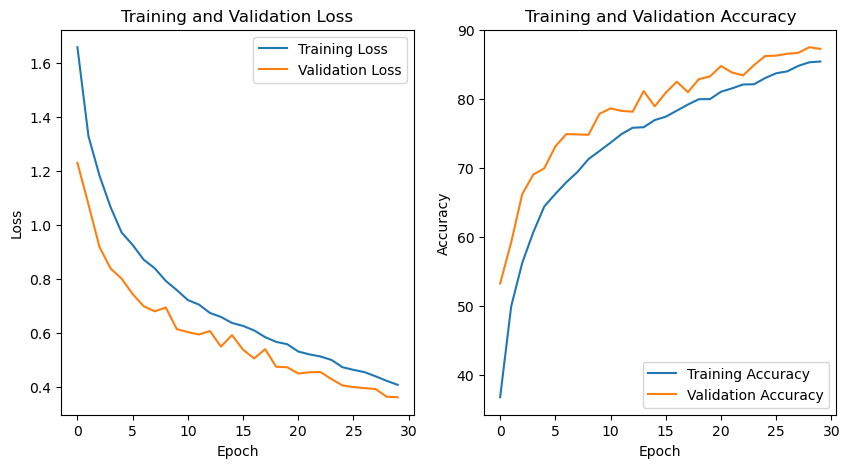

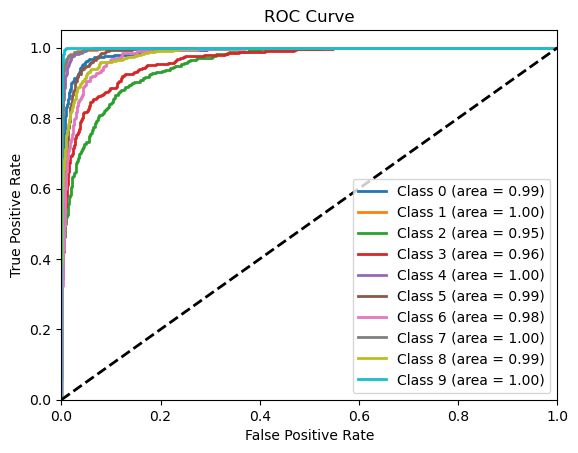

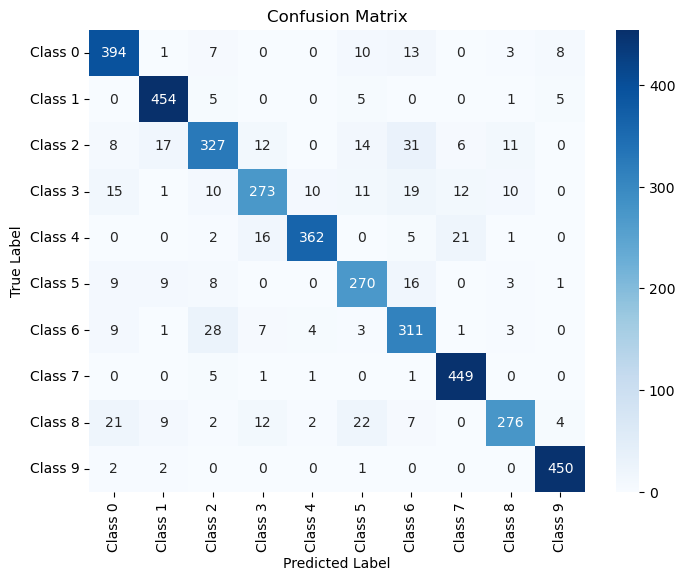

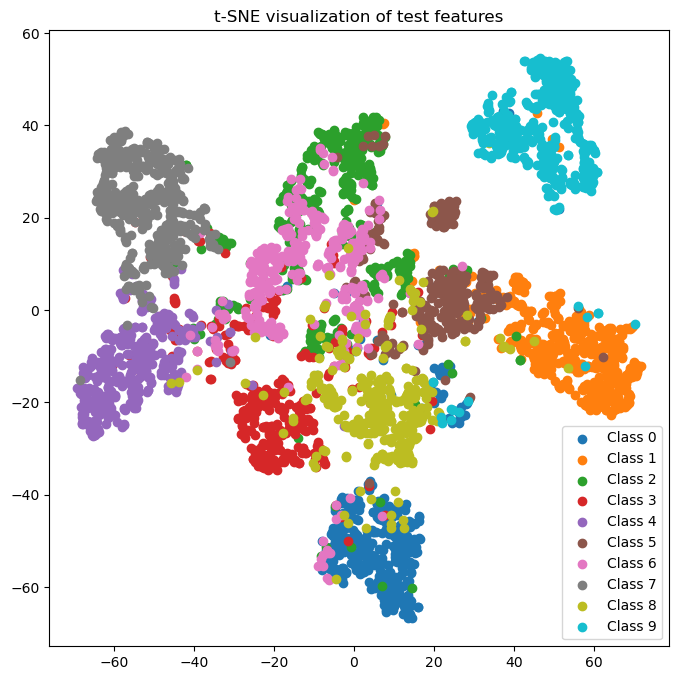

In [9]:
plotter = EvaluationAndPlotting()
plotter.evaluate_and_plot(model, test_loader, device, 10, trainer.train_losses, trainer.train_accs, trainer.val_losses, trainer.val_accs)